In [1]:
using CUDA, Flux, JLD2

In [2]:
Threads.nthreads()

16

In [3]:
dev = gpu
β = 1.0

1.0

In [4]:
include("utils/train.jl")

In [ ]:
'''
Eᵢ=a0 b0/λ - λ/2(u²-w²)
u(t+1) = u(t) exp(-η ∇Eᵢ)/∑u(t) exp(-η ∇Eⱼ)
∇Eᵢ=-λᵢ uᵢ
rᵢ⁺(t) = exp(η λᵢ uᵢ(t))
rᵢ⁻(t) = exp(-η λᵢ uᵢ(t))
qᵢ⁺(t) = exp(-η λᵢ wᵢ(t))
qᵢ⁻(t) = exp(+η λᵢ wᵢ(t))

1. Initialize \vec{u} = \vec{0}, \vec{w} = \vec{0} and normalization values U1 and U2
2a. uᵢ⁺(t+1) = U1 ⋅ uᵢ⁺(t) rᵢ⁺(t)/∑ⱼuⱼ⁺(t) rⱼ⁺(t) + uⱼ⁻(t) rⱼ⁻(t)
2b. uᵢ⁻(t+1) = U1 ⋅ uᵢ⁻(t) rᵢ⁻(t)/∑ⱼuⱼ⁺(t) rⱼ⁺(t) + uⱼ⁻(t) rⱼ⁻(t)
2c. wᵢ⁺(t+1) = U2 ⋅ wᵢ⁺(t) qᵢ⁺(t)/∑ⱼwⱼ⁺(t) qⱼ⁺(t) + wⱼ⁻(t) qⱼ⁻(t)
2d. wᵢ⁻(t+1) = U2 ⋅ wᵢ⁻(t) qᵢ⁻(t)/∑ⱼwⱼ⁺(t) qⱼ⁺(t) + wⱼ⁻(t) qⱼ⁻(t)
3a. uᵢ(t+1) = uᵢ⁺(t+1) - uᵢ⁻(t+1)
3b. wᵢ(t+1) = wᵢ⁺(t+1) - wᵢ⁻(t+1)
'''

In [5]:
function ExpGradpm(λ, U1, U2, u1, u2; η=0.001, nmax=500)
    # u = ones(size(λ,1)) ./ size(λ,1) .* U1 #.+ rand()
    # w = ones(size(λ,1)) ./ size(λ,1) .* U2 #.+ rand()
    u = zeros(size(λ,1)) .+ rand()
    w = zeros(size(λ,1)) .+ rand()
    uplus = u
    uminus = u
    wplus = w
    wminus = w
    
    # λmax = mean(F.S)
    λmax = maximum(F.S)+1
    
    tracker_u, tracker_w = [], []
    for i in 1:nmax
        rplus = exp.(η .* (λ .* u .- λmax .* (u .- u1)))
        rminus = exp.(- η .* (λ .* u .- λmax .* (u .- u1)))
        qplus = exp.(- η .* (λ .* w .+ λmax .* (w .- u2)))
        qminus = exp.(η .* (λ .* w .+ λmax .* (w .- u2)))
        # qplus = exp.(- η .* (λ .* w .- 0 .* (w .- 0.5)))
        # qminus = exp.(η .* (λ .* w .- 0 .* (w .- 0.5)))
        
        uplus = U1 .* uplus .* rplus / sum(uplus .* rplus .+ uminus .* rminus)
        uminus = U1 .* uminus .* rminus / sum(uplus .* rplus .+ uminus .* rminus)
        wplus = U2 .* wplus .* qplus / sum(wplus .* qplus .+ wminus .* qminus)
        wminus = U2 .* wminus .* qminus / sum(wplus .* qplus .+ wminus .* qminus)
        u = uplus .- uminus
        w = wplus .- wminus
        # @info sum(rplus), sum(rminus), sum(qplus), sum(qminus)
        append!(tracker_u, sum(u))
        append!(tracker_w, sum(w))
    end
    return u, w, tracker_u, tracker_w
end

function uwToxy(F, u, w) 
    λ = cpu(F.S)
    a0 = cpu(F.U' * J.a)[1:size(λ,1)]
    b0 = cpu(F.Vt * J.b)

    s = size(u,1)
    Rot = Tridiagonal([ isodd(i) ? 1 : 0 for i in 1:2*s-1] , [1 for i in 1:2*s] , [ isodd(i) ? -1 : 0 for i in 1:2*s-1])
    uw = Array(reshape(hcat(u, w)',:))
    xysp = Array(reshape(hcat(-b0 ./ λ, -a0 ./ λ)',:))
    xy = xysp + 1/√2 * Rot * uw
    x, y = reshape(xy', 2,:)'[:,1], reshape(xy', 2,:)'[:,2]
    return x, y
end

# function uwToxyDet(F, Γu, Γw, u0, w0)
#     λ = cpu(F.S)
#     a0 = cpu(F.U' * J.a)[1:size(λ,1)]
#     b0 = cpu(F.Vt * J.b)
    
#     u = Γu .* u0 ./ (Γu .- λ)
#     w = Γw .* w0 ./ (Γw .+ λ)

#     s = size(u,1)
#     Rot = Tridiagonal([ isodd(i) ? 1 : 0 for i in 1:2*s-1] , [1 for i in 1:2*s] , [ isodd(i) ? -1 : 0 for i in 1:2*s-1])
#     uw = Array(reshape(hcat(u, w)',:))
#     xysp = Array(reshape(hcat(-b0 ./ λ, -a0 ./ λ)',:))
#     xy = xysp + 1/√2 * Rot * uw
#     x, y = reshape(xy', 2,:)'[:,1], reshape(xy', 2,:)'[:,2]
#     return x, y
# end   

uwToxy (generic function with 1 method)

In [6]:
modelName = "CD-500-T1000-5-BW-replica2-L"
rbm, J, m, hparams, opt = loadModel(modelName, gpu);
x_i, y_i = loadData(; hparams, dsName="MNIST01", numbers=collect(0:9), testset=true);
TS = Test(x_i,y_i)
dict = loadDict(modelName);

[ Info: /home/javier/Projects/RBM/Results/models/CD-500-T1000-5-BW-replica2-L
[ Info: Loadding model J_1000.
[ Info: 10000


In [7]:
J.w = gpu(J.w)
J.b = gpu(J.b)
J.a = gpu(J.a)
F = LinearAlgebra.svd(J.w, full=true);

(sum(u), sum(w)) = (320.16916973153, 4.559921696792732)
(sum(x), sum(y)) = (218.228834886584, 169.1369308930349)


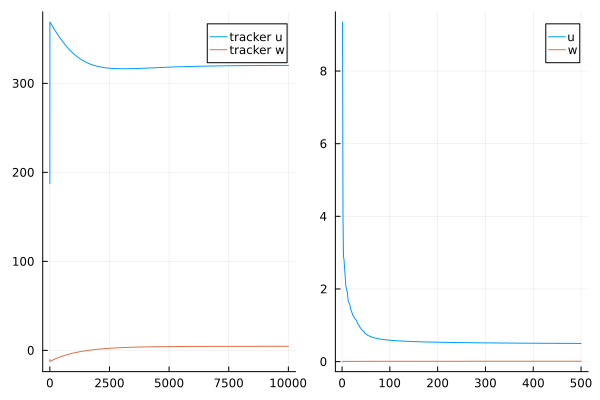

In [430]:
u, w, tracker_u, tracker_w = ExpGradpm(cpu(F.S), 450, 150, 0.5, 0.01; η=0.0001, nmax=10000)
x,y = uwToxy(F,u,w);
@show sum(u), sum(w)
@show sum(x), sum(y)
p1 = plot(tracker_u, label="tracker u")
p1 = plot!(tracker_w, label="tracker w")
p2 = plot(u, label="u")
p2 = plot!(w, label="w")
plot(p1,p2)

In [431]:
h = Array{Float32}(sign.(rand(hparams.nh, hparams.batch_size) |> dev .< σ.( F.V * dev(cat(Diagonal(F.S), (zeros(hparams.nv-hparams.nh,hparams.nh)),dims=1))' * dev(vcat(x, zeros(784-500))) + J.b))) |> dev
v = Array{Float32}(sign.(rand(hparams.nv, hparams.batch_size) |> dev .< σ.( F.U * dev(cat(Diagonal(F.S), (zeros(hparams.nv-hparams.nh,hparams.nh)),dims=1)) * dev(y) + J.a))) |> dev;


In [433]:
sum(v, dims=1)

1×500 CuArray{Float32, 2, CUDA.Mem.DeviceBuffer}:
 219.0  217.0  227.0  221.0  223.0  …  231.0  210.0  216.0  221.0  222.0

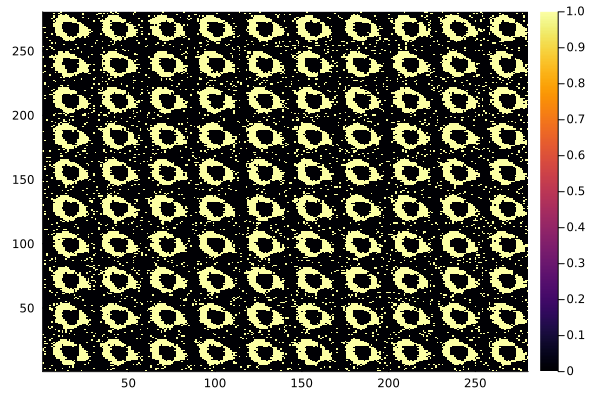

In [434]:
lnum=10
heatmap(cat([cat([reshape(cpu(v)[:,i+j*lnum],28,28) for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1))

In [388]:
rbm.v = v |> dev
for i in 1:1
    # display(plotLandscapes(rbm, J, lnum ; τ=0, TS, dev, hparams))
    rbm.h = Array{Float32}(sign.(rand(hparams.nh, hparams.batch_size) |> dev .< σ.(β .* (J.w' * rbm.v .+ J.b)))) |> dev 
    rbm.v = Array{Float32}(sign.(rand(hparams.nv, hparams.batch_size) |> dev .< σ.(β .* (J.w * rbm.h .+ J.a)))) |> dev  
end

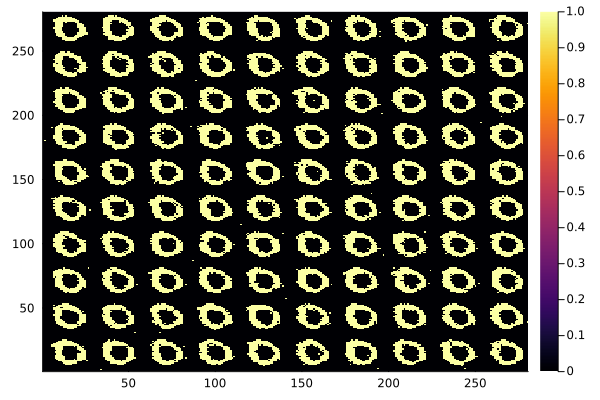

In [389]:
lnum=10
heatmap(cat([cat([reshape(cpu(rbm.v)[:,i+j*lnum],28,28) for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1))

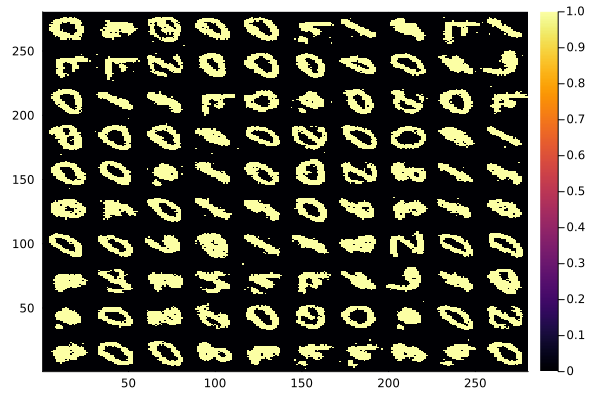

In [270]:
rbm.h = Array{Float32}(sign.(rand(hparams.nh, hparams.batch_size) |> dev .< σ.(β .* (J.w' * dev(rand(hparams.nv,hparams.batch_size)) .+ J.b)))) |> dev 
for i in 1:500
    # display(plotLandscapes(rbm, J, lnum ; τ=0, TS, dev, hparams))
    rbm.v = Array{Float32}(sign.(rand(hparams.nv, hparams.batch_size) |> dev .< σ.(β .* (J.w * rbm.h .+ J.a)))) |> dev  
    rbm.h = Array{Float32}(sign.(rand(hparams.nh, hparams.batch_size) |> dev .< σ.(β .* (J.w' * rbm.v .+ J.b)))) |> dev 
end
lnum=10
heatmap(cat([cat([reshape(cpu(rbm.v)[:,i+j*lnum],28,28) for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1))

In [327]:
u, w, tracker_u, tracker_w = ExpGradpm(cpu(F.S), 600, 600, 0.9, 0.9; η=0.0001, nmax=10000)
x,y = uwToxy(F,u,w);

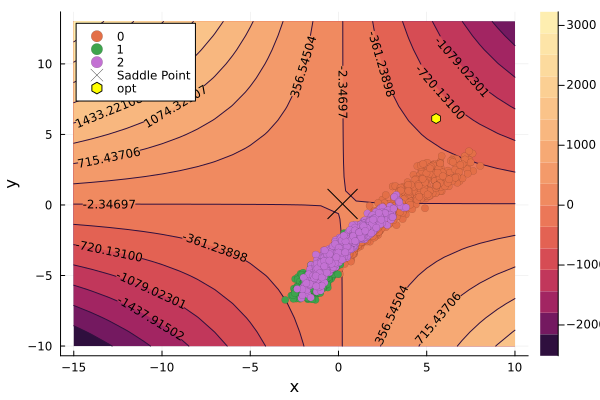

In [447]:
enLandIdx = 2
p = plot(-15:10, -10:13, (x,y)->f(x,y,enLandIdx, a0[:], b0[:], λ[:]), st=:contourf, c=cgrad(:matter, 105, rev=true, scale = :exp, categorical=false), 
    xlabel="x", ylabel="y", clabels=true)
for num_label in string.(collect(0:2))
    plot!(x_s[num_label][enLandIdx,:], y_s[num_label][enLandIdx,:], st=:scatter, markerstrokewidth=0.1, label=num_label)
end
plot!([-b0[enLandIdx]/λ[enLandIdx]],[-a0[enLandIdx]/λ[enLandIdx]], ms=15, st=:scatter, c=:black, markershape=:x, label="Saddle Point")
plot!([x[enLandIdx]], [y[enLandIdx]], ms=5, st=:scatter, c=:yellow, markershape=:hexagon, label="opt")


In [444]:
############### # Previous is numerical. Fwd is analytical

In [310]:
x_s = Dict()
y_s = Dict()
v_s = Dict()
h_s = Dict()
# R = Dict()
# Θ = Dict()

for num_label in 0:9
    v = gpu(x_i[:,y_i .== num_label])
    h = Array{Float32}(sign.(rand(500, size(v,2)) |> dev .< σ.(β .* (dev(J.w)' * v .+ dev(J.b))))) |> dev

    x = cpu(F.U' * v)
    y = cpu(F.Vt * h);
    
    x_s[string(num_label)] = x
    y_s[string(num_label)] = y;
    
    v_s[string(num_label)] = cpu(v)
    h_s[string(num_label)] = cpu(h);

end

In [11]:
f(x,y,i, a0, b0, λ) = - (a0[i]*x + b0[i]*y + λ[i]*x*y )
λ = cpu(F.S)
a0 = cpu(F.U' * J.a)[1:size(λ,1)]
b0 = cpu(F.Vt * J.b);

In [139]:
Γu=fill(cpu(maximum(F.S)+1), size(F.S,1))
Γw=fill(cpu(maximum(F.S)+1), size(F.S,1))
u0=ones(size(F.S,1)) * (1.1)
w0=ones(size(F.S,1)) * 1.0

λ = cpu(F.S)
u = Γu .* u0 ./ (Γu .- λ)
w = Γw .* w0 ./ (Γw .+ λ)

x,y = uwToxy(F,u,w);
# x,y = uwToxyDet(F, Γu, Γw, u0, w0)
@show sum(Γu .* u0 ./ (Γu .- λ)), sum(Γw .* w0 ./ (Γw .+ λ))
@show sum(x), sum(y)

(sum((Γu .* u0) ./ (Γu .- λ)), sum((Γw .* w0) ./ (Γw .+ λ))) = (704.6096229402733, 456.72435797683187)
(sum(x), sum(y)) = (170.3407472079078, 760.705921424375)


(170.3407472079078, 760.705921424375)

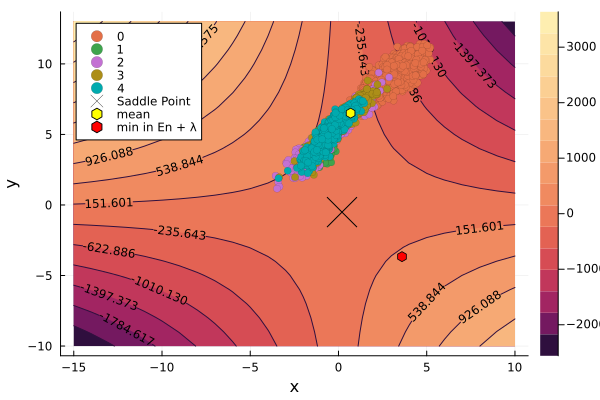

In [236]:
enLandIdx = 1
p = plot(-15:10, -10:13, (x,y)->f(x,y,enLandIdx, a0[:], b0[:], λ[:]), st=:contourf, c=cgrad(:matter, 105, rev=true, scale = :exp, categorical=false), 
    xlabel="x", ylabel="y", clabels=true)
for num_label in string.(collect(0:4))
    plot!(x_s[num_label][enLandIdx,:], y_s[num_label][enLandIdx,:], st=:scatter, markerstrokewidth=0.1, label=num_label)
end
plot!([-b0[enLandIdx]/λ[enLandIdx]],[-a0[enLandIdx]/λ[enLandIdx]], ms=15, st=:scatter, c=:black, markershape=:x, label="Saddle Point")
plot!([xstar[enLandIdx]], [ystar[enLandIdx]], ms=5, st=:scatter, c=:yellow, markershape=:hexagon, label="mean")
plot!([x0[enLandIdx]], [y0[enLandIdx]], ms=5, st=:scatter, c=:red, markershape=:hexagon, label="min in En + λ")


In [301]:
# h = Array{Float32}(sign.(rand(hparams.nh, hparams.batch_size) |> dev .< σ.( F.V * dev(cat(Diagonal(F.S), (zeros(hparams.nv-hparams.nh,hparams.nh)),dims=1))' * dev(vcat(x, zeros(784-500))) + J.b))) |> dev
# v = Array{Float32}(sign.(rand(hparams.nv, hparams.batch_size) |> dev .< σ.( F.U * dev(cat(Diagonal(F.S), (zeros(hparams.nv-hparams.nh,hparams.nh)),dims=1)) * dev(y) + J.a))) |> dev;

h = Array{Float32}(sign.(rand(hparams.nh, hparams.batch_size) |> dev .< σ.( F.V * dev(cat(Diagonal(F.S), (zeros(hparams.nv-hparams.nh,hparams.nh)),dims=1))' * dev(vcat(xstar, zeros(784-500))) + J.b))) |> dev
v = Array{Float32}(sign.(rand(hparams.nv, hparams.batch_size) |> dev .< σ.( F.U * dev(cat(Diagonal(F.S), (zeros(hparams.nv-hparams.nh,hparams.nh)),dims=1)) * dev(ystar) + J.a))) |> dev;

h = Array{Float32}(sign.(rand(hparams.nh, hparams.batch_size) |> dev .< σ.( F.V * dev(cat(Diagonal(F.S), (zeros(hparams.nv-hparams.nh,hparams.nh)),dims=1))' * dev(vcat(xNoise, zeros(784-500, hparams.batch_size))) .+ J.b))) |> dev
v = Array{Float32}(sign.(rand(hparams.nv, hparams.batch_size) |> dev .< σ.( F.U * dev(cat(Diagonal(F.S), (zeros(hparams.nv-hparams.nh,hparams.nh)),dims=1)) * dev(yNoise) .+ J.a))) |> dev;


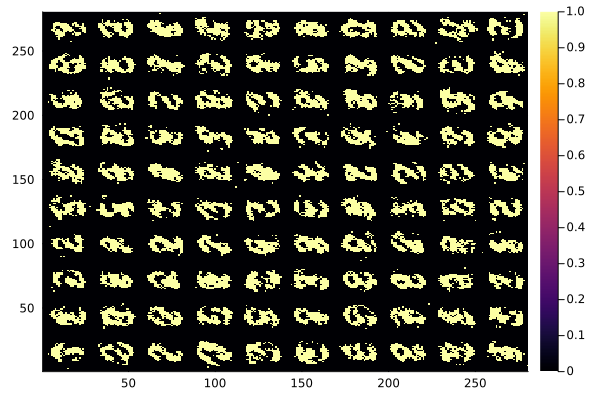

In [302]:
lnum=10
heatmap(cat([cat([reshape(cpu(v)[:,i+j*lnum],28,28) for i in 1:lnum]..., dims=2) for j in 0:lnum-1]...,dims=1))

In [295]:
s=500
num_label = "8"
s2 = size(x_s[num_label],2)
Rot = Tridiagonal([ isodd(i) ? 1 : 0 for i in 1:2*s-1] , [1 for i in 1:2*s] , [ isodd(i) ? -1 : 0 for i in 1:2*s-1])

xyMinusSp = vcat(x_s[num_label][1:500,:] .+ b0 ./ λ, y_s[num_label][1:500,:] .+ a0 ./ λ)[Array(reshape(hcat(1:500, 501:1000)',:)),:]
uw0 = inv(1/√2 * Rot) * xyMinusSp
uData, wData = hcat([reshape(uw0[:,i]', 2,:)'[:,1] for i in 1:s2]...), hcat([reshape(uw0[:,i]', 2,:)'[:,2] for i in 1:s2]...);

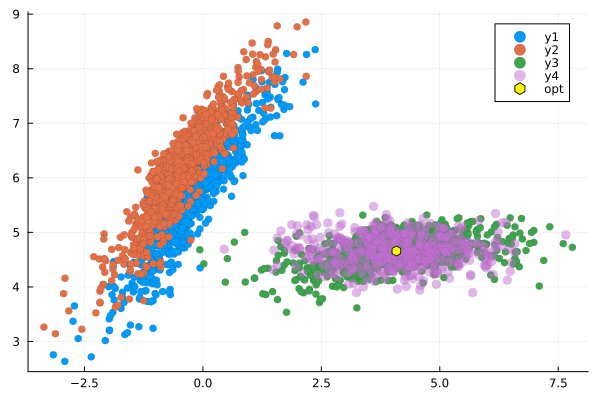

In [304]:
idx = 1
plot(x_s[num_label][idx,:],y_s[num_label][idx,:], st=:scatter, markerstrokewidth=0.1)
plot!(x_s[num_label][idx,:] .+ b0[idx] ./ λ[idx], y_s[num_label][idx,:] .+ a0[idx] ./ λ[idx], st=:scatter, markerstrokewidth=0.1)
plot!(uData[idx,:], wData[idx,:], st=:scatter, markerstrokewidth=0.1)
plot!(uNoise[idx,:], wNoise[idx,:], st=:scatter, markerstrokewidth=0.1, ms=5, opacity=0.5)
ustar = reshape(mean(uData, dims=2),:)
wstar = reshape(mean(wData, dims=2),:)
σ2u = reshape(var(uData, dims=2),:)
σ2w = reshape(var(wData, dims=2),:)
plot!([ustar[idx]], [wstar[idx]], ms=5, st=:scatter, c=:yellow, markershape=:hexagon, label="opt")

In [297]:
Γu = λ .+ 1 ./ σ2u
Γw = λ .- 1 ./ σ2w
u0 = ustar ./ (λ .* σ2u .+ 1)
w0 = wstar ./ ( .- λ .* σ2w .+ 1);

In [298]:
x0, y0 = uwToxy(F,u0,w0)
xstar, ystar = uwToxy(F,ustar,wstar)

([-0.20696021735026005, 0.34031690449073104, -0.7622233736625212, 1.614843350752913, 0.3954954110162481, -1.0674844153332517, 0.7685820097046352, -1.9244270422773178, -3.004238691785249, 0.5120717883492533  …  -0.027000162390951488, 0.022421277279236485, -0.017964617672417305, -0.008341394410730008, 0.05019961196540379, -0.008211179435622107, 0.03983499828794912, 0.05944889575793422, 0.022672762708008, 0.04300440116584259], [5.67484946735586, -3.151611621000133, -0.7385272587395191, 0.12793769280080192, 4.096057378539709, 0.32783836682826256, 0.04792679274106654, -3.076126881674299, -4.448405258219832, -1.6088855157795616  …  0.08446379780034707, 0.019410947265076306, -0.11321166065926924, 0.0710167199434455, 0.08517711216420665, 0.022415555233338047, 0.04271804870276341, 0.109211098854054, 0.036601945933803726, -0.03672130347767233])

In [299]:
# plot(wstar)
noise_u = randn(500, hparams.batch_size)
noise_w = randn(500, hparams.batch_size)
uNoise = ustar .+ noise_u .* .√ σ2u
wNoise = wstar .+ noise_w .* .√ σ2w
qwert = [uwToxy(F,uNoise[:,i],wNoise[:,i]) for i in 1: hparams.batch_size];
xNoise, yNoise = hcat([qwert[i][1] for i in 1: hparams.batch_size]...), hcat([qwert[i][2] for i in 1: hparams.batch_size]...)

([0.3930433129368818 -0.5904660323727073 … -0.840374172822087 0.3013870485777179; 1.4400361349756738 2.9995118383983517 … -0.5694165702655294 -1.5529604257301233; … ; 0.13601506111517903 -0.058165258188661584 … -0.30606362293114536 0.31204849380272803; -0.04097342938648918 0.508240042965908 … 0.15156769124493685 0.34970385653443925], [5.558129759680691 5.917006559462832 … 4.607321796864548 6.149552610398425; -2.28296843891498 -0.8644866785482436 … -3.763233797734811 -4.863702817851419; … ; -0.16474659172935568 -0.569862398861724 … -0.039848602285807555 0.3682998188090646; -0.19267972475589001 -0.3607080805529277 … 0.10559524674840226 -0.07955535052644791])

In [237]:
# Γu=fill(cpu(maximum(F.S)+1), size(F.S,1))
# Γw=fill(cpu(maximum(F.S)+1), size(F.S,1))
# u0=ones(size(F.S,1)) * (1.1)
# w0=ones(size(F.S,1)) * 1.0

λ = cpu(F.S)
u = Γu .* u0 ./ (Γu .- λ)
w = Γw .* w0 ./ (Γw .+ λ)

x,y = uwToxy(F,u,w);
# x,y = uwToxyDet(F, Γu, Γw, u0, w0)
@show sum(Γu .* u0 ./ (Γu .- λ)), sum(Γw .* w0 ./ (Γw .+ λ))
@show sum(x), sum(y)

(sum((Γu .* u0) ./ (Γu .- λ)), sum((Γw .* w0) ./ (Γw .+ λ))) = (45.17467991689203, 267.3367805435049)
(sum(x), sum(y)) = (-162.03293247969177, 160.4977611855798)


(-162.03293247969177, 160.4977611855798)

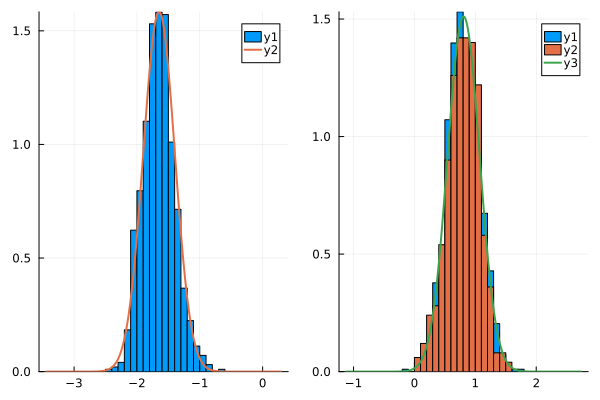

In [269]:
idx = 400
μu = ustar[idx]
σ2uu = σ2u[idx]

μw = wstar[idx]
σ2ww = σ2w[idx]

p1 = plot(uData[idx,:], st=:histogram, bins=20, normalize=true) # yaxis = (:log10, (0.00001,Inf)),
p1 = plot!(minimum(uData[idx,:])-1:0.01:1+maximum(uData[idx,:]), x->1/√(2π*σ2uu) * exp(-(x-μu)^2/(2*σ2uu)),lw=2)
p2 = plot(wData[idx,:], st=:histogram, bins=20,  normalize=true)
p2 = plot!(wNoise[idx,:], st=:histogram, bins=20,  normalize=true)
p2 = plot!(minimum(wData[idx,:])-1:0.01:1+maximum(wData[idx,:]), x->1/√(2π*σ2ww) * exp(-(x-μw)^2/(2*σ2ww)), lw=2)
plot(p1,p2)

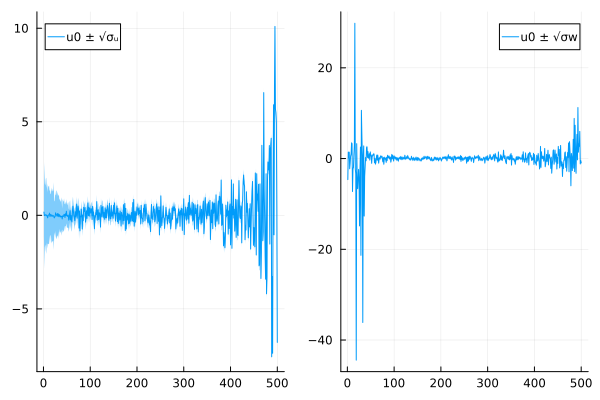

In [239]:
plot(σ2u)
plot(σ2w)
p1 = plot(u0, ribbon=.√σ2u, label="u0 ± √σᵤ")
p2 = plot(w0, ribbon=.√σ2w, label="u0 ± √σw")
plot(p1,p2)

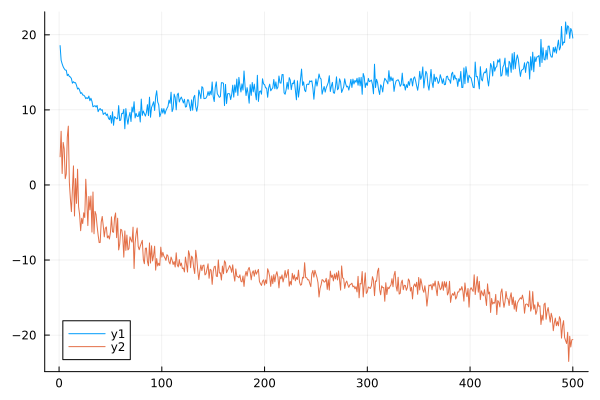

In [303]:
plot(Γu)
plot!(Γw)

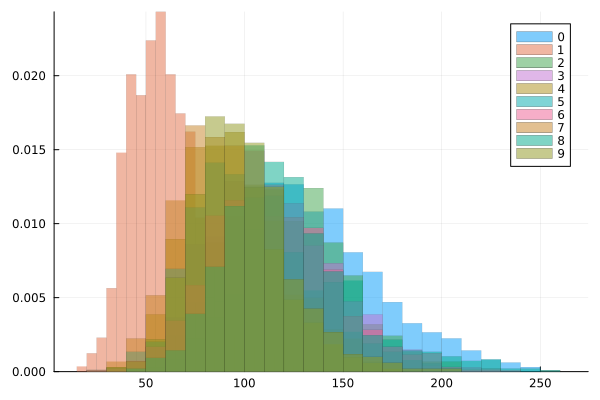

In [242]:
plot()
for j in 0:9
    plot!(diag(x_s[string(j)]' * x_s[string(j)]), st=:histogram, fillalpha=0.5, lw=0, label=j, normalized=true)
end
plot!()

In [ ]:
# Compute avg in v-h space -> project to x-y and then to u-w

In [365]:
v_mean = reshape(mean(v_s[num_label], dims=2),:)
x_mean = (cpu(F.U') * v_mean)[1:hparams.nh]

h_mean = reshape(mean(h_s[num_label], dims=2),:)
y_mean = cpu(F.Vt) * h_mean

x_σ = diag(cpu(F.U') * mean([v_s[num_label][:,i] .* v_s[num_label][:,i]' for i in 1:size(v_s[num_label],2)]) * cpu(F.U))[1:hparams.nh]
y_σ = diag(cpu(F.Vt) * mean([h_s[num_label][:,i] .* h_s[num_label][:,i]' for i in 1:size(h_s[num_label],2)]) * cpu(F.V))
xy = diag(cpu(F.Vt) * mean([h_s[num_label][:,i] .* v_s[num_label][:,i]' for i in 1:size(h_s[num_label],2)]) * cpu(F.U))
xsp = - cpu(F.Vt * J.b) ./ λ
ysp = - cpu(F.U' * J.a)[1:hparams.nh] ./ λ

umean = 1/√2 .* (y_mean + x_mean - ysp - xsp)
u_σ =  1/2 .* (y_σ + x_σ + (ysp+xsp) .^2 + 2 .* xy - 2 .* (x_mean + y_mean) .* (xsp + ysp) )
σ_2u = u_σ .- umean .^ 2

wmean = 1/√2 .* (y_mean - x_mean - ysp + xsp)
w_σ =  1/2 .* (y_σ + x_σ + (ysp-xsp) .^2 - 2 .* xy - 2 .* (y_mean - x_mean ) .* (ysp - xsp) )
σ_2w = w_σ .- wmean .^ 2 ;

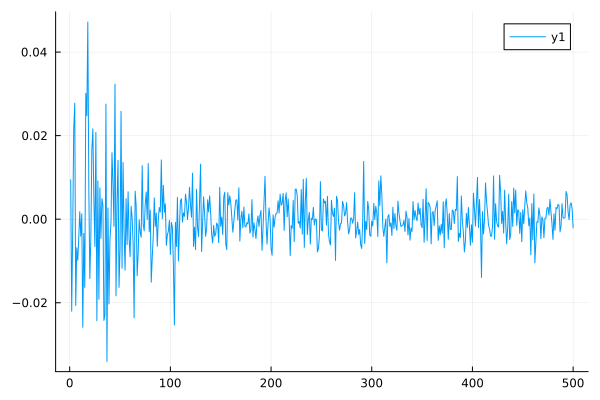

In [364]:
plot(σ_2u)
plot!(σ2u)
plot(σ_2u .- σ2u)

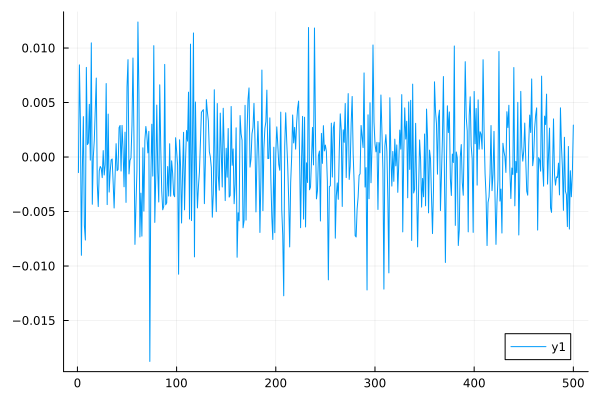

In [363]:
plot(σ_2w)
plot!(σ2w)
plot(σ2w .- σ_2w)